In [3]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
responses = []
with bz2.BZ2File('./data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:16, 1471.24it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [7]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Смотрим распределение отзывов по городам и банкакм. Посмотрим на гистограммы рейтингов и их распределения по городам и банкам. Но сперва собирем датасет.

In [24]:
df = pd.DataFrame(responses)

In [25]:
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


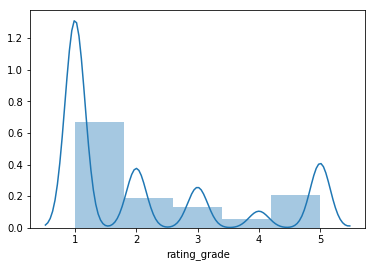

In [52]:
#Распределение рейтингов по отзывам. Без рейтинга исключены.
sns.distplot(df.rating_grade.dropna(), bins=5)

Ожидаемо много негатива. Стоит задуматься о балансировке классов. Посмотрим на данные по городам и банкам

In [60]:
df.bank_name.unique()[:20]

array(['Бинбанк', 'Сбербанк России', 'ОТП Банк', 'Гагаринский',
       'Тинькофф Банк', 'Восточный Экспресс Банк', 'ВТБ 24', 'Альфа-Банк',
       'БИНБАНК кредитные карты', 'МТС Банк', 'Совкомбанк',
       'Россельхозбанк', 'Московский Кредитный Банк', 'МДМ Банк',
       'Хоум Кредит Банк', 'Бенифит-Банк',
       'Уральский Банк Реконструкции и Развития', 'Русский Стандарт',
       'Лето Банк', 'Петрокоммерц'], dtype=object)

In [64]:
df.city.sort_values().unique()[:20]

array(['г.  (Красногорск)', 'г.  (Москва)', 'г.  (Россия)',
       'г.  (Ханты-Мансийский автономный округ)', 'г. -', 'г. ...',
       'г. ....', 'г. .......', 'г. ........', 'г. 047169000 или 5939',
       'г. 1-е Новоспасское', 'г. 111', 'г. 1111', 'г. 112', 'г. 112422',
       'г. 140051, МО, Люберецкий район, Красково',
       'г. 140205,Pobeda street,16,39,city of Voscresensk,Moscow region',
       'г. 143420 Московская область, Красногорский район, посёлок дачного хозяйства Архангельское, д.4,кв.2',
       'г. 1Ёсаратов', 'г. 2-я Гавриловка'], dtype=object)

Как видим, наименования банков выбирались из списков, а город указывался пользователем. Визулизируем распределение отзывов по банкам.

In [73]:
df.groupby(by='bank_name').count().sort_values(by='text', ascending=False)['text'][:10]

bank_name
Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: text, dtype: int64

In [53]:
for i in range(7,15):
    print(df.text.iloc[i])

Был крайне удивлён новостью от 27/28 мая - об  унификации . "Удивлён" - это, пожалуй, плохо подходит, так как отражает положительную эмоцию. Я же был, скорее, ошарашен и удручён. Считаю данную  унификацию  неправомерной и незаконной. Незаконность постараюсь доказывать и отстаивать свои права (как одна из сторон акцептованного договора). Допускаю, что дело будет проиграно. Но и роль терпилы, молча принимающего такой разворот событий, мне претит. Если всё же данные действия банка будут сочтены правомерными, то постараюсь со своей стороны применять в отношении банка тоже вполне законные, но, скажем так, некрасивые действия. Кстати, для справки, невозврат взятого кредита, тоже признается законным при некоторых оговорках.
Сотрудники банка Восточный систематически сообщаю мои персональные данные по телефону моим близким. Звонят не представляясь и в грубой форме сообщаю всю персональную информацию, что является нарушением закона №98-ФЗ о коммерческой тайне. Так же это может очень негативно ск

In [54]:
# добавить названия банков в стопслова после лематизации названий и корпуса

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined